In [1]:
%pylab inline
from useful_function import *
from sklearn.metrics import pairwise_distances
from sklearn.svm import SVDD

Populating the interactive namespace from numpy and matplotlib


#### Distance Calculation Functions

In [2]:
def rbf_kernel(X, Y=None, gamma=1):
    if Y is None:
        Y = X
    distances = pairwise_distances(X, Y) ** 2
    return exp(-gamma * distances)

In [3]:
def rbf_distances(X, Y=None, gamma=1):
    if Y is None:
        Y = X
    return 2 - rbf_kernel(X, Y, gamma)

In [4]:
def nearest_neighbour_distance(distance_matrix):
    return distance_matrix.min()

In [5]:
def farthest_neighbour_distance(distance_matrix):
    return distance_matrix.max()    

In [6]:
def group_mean_distance(distance_matrix):
    return mean(distance_matrix)

In [7]:
def group_median_distance(distance_matrix):
    return median(distance_matrix)

In [8]:
def group_center_distance(distance_matrix):
    return 2 - 2 / prod(distance_matrix.shape) * sum(1 - distance_matrix / 2)

In [9]:
def process_data_set(data):
    normal_data, anomaly_data = split_anomaly_normal_data(data)
    distance_metrics = [nearest_neighbour_distance, farthest_neighbour_distance, 
                        group_mean_distance, group_median_distance, group_center_distance]
    normal_train, normal_validate, normal_test = split_data_set(normal_data, 3)
    anomaly_train, anomaly_validate, anomaly_test = split_data_set(anomaly_data, 3)
    results = {}
    all_gammas = np.logspace(-10, 10, 50)
    for distance in selection_technics:
        start = time.time()
        metrics = model_selection(concatenate([normal_validate, anomaly_validate]), all_gammas, techique)
        duration = time.time() - start
        best_index = np.argmin(metrics)
        best_score = metrics[best_index]
        all_best_gamma = metrics == best_score
        possible_results = all_gammas[all_best_gamma]
        best_gamma = np.max(possible_results)
        fn, fp, auc = validate_gamma(concatenate([normal_train, anomaly_train]), normal_test, anomaly_test, best_gamma)
        results[str(technic).split()[1]] = {'false negative': fn, 'false positive': fp, 'auc': auc, 'time':duration}
    return results

In [10]:
def calculate_radius(clf):
    all_support_vectors = clf.support_vectors_
    first_support_vector = clf.support_vectors_[0, :]
    dual_coef = clf.dual_coef_
    gamma = clf.gamma
    test_vector_norm = 1
    second_part = rbf_kernel(all_support_vectors, first_support_vector, gamma)
    #print "second_vector", second_part
    second_part = dot(dual_coef, second_part)
    #print second_part
    third_part = dot(dual_coef, dot(rbf_kernel(all_support_vectors, all_support_vectors, gamma), dual_coef.T))[0, 0]
    radius = (test_vector_norm - 2 * second_part + third_part)
    return radius[0, 0]

In [11]:
def combinatorial_metrics(clf, validate_x, distance_function):
    y = clf.predict(validate_x)
    inliers_indices = (y == 1).nonzero()[0]
    outliers_indices = (y == -1).nonzero()[0]
    if len(outliers_indices) == 0 or len(inliers_indices) == 0:
        distance = spacing(1)
    else:
        inliers_set = validate_x[inliers_indices, :]
        outliers_set = validate_x[outliers_indices, :]
        distance_matrix = rbf_distances(inliers_set, outliers_set)
        distance = distance_function(distance_matrix)
    radius = calculate_radius(clf)
    return radius / distance

In [19]:
data = generate_dataset(1000, dim=2)
normal_data, anomaly_data = split_anomaly_normal_data(data)
distance_metrics = [nearest_neighbour_distance, farthest_neighbour_distance, 
                        group_mean_distance, group_median_distance, group_center_distance]
normal_train, normal_validate, normal_test = split_data_set(normal_data, 3)
anomaly_train, anomaly_validate, anomaly_test = split_data_set(anomaly_data, 3)
train_x = concatenate([normal_train, anomaly_train])
validate_x = concatenate([normal_validate, anomaly_validate])
test_x = concatenate([normal_test, anomaly_test])
test_y = array([1] * len(normal_test) + [-1] * len(anomaly_test))

In [39]:
all_nearest_neighbour_distance = []
all_farthest_neighbour_distance = []
all_group_mean_distance = []
all_group_median_distance = []
all_group_center_distance = []

In [40]:
all_gammas = np.logspace(-10, 10, 50)

for gamma in all_gammas:
    clf = SVDD(C = 1.0 / 100, kernel='rbf', gamma=gamma)
    clf.fit(train_x)
    all_nearest_neighbour_distance.append(combinatorial_metrics(clf, validate_x, nearest_neighbour_distance))
    all_farthest_neighbour_distance.append(combinatorial_metrics(clf, validate_x, farthest_neighbour_distance))
    all_group_mean_distance.append(combinatorial_metrics(clf, validate_x, group_mean_distance))
    all_group_median_distance.append(combinatorial_metrics(clf, validate_x, group_median_distance))
    all_group_center_distance.append(combinatorial_metrics(clf, validate_x, group_center_distance))

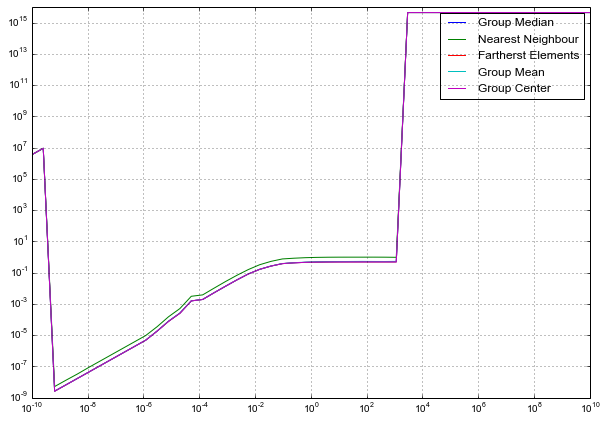

In [45]:
figsize(10, 7)
plot(all_gammas, all_group_median_distance, label='Group Median')
plot(all_gammas, all_nearest_neighbour_distance, label='Nearest Neighbour')
plot(all_gammas, all_farthest_neighbour_distance, label='Fartherst Elements')
plot(all_gammas, all_group_mean_distance, label='Group Mean')
plot(all_gammas,  all_group_center_distance, label='Group Center')
yscale('log')
xscale('log')
grid(True)
legend(loc='best')